# Task F

In [11]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

from models import *
from utils import * 
from optimizers import * 

# Create data
x = np.arange(0, 1, 0.05)
y = np.arange(0, 1, 0.05)
x, y = np.meshgrid(x, y)

# Compute z
z = FrankeFunction(x, y)

# Create features as pairs of (x, y)
features = np.stack([x.ravel(), y.ravel()], axis=1)
outputs = z.ravel()

# Split dataset into train and test set
x_train, x_test, y_train, y_test = train_test_split(features, outputs, test_size=0.2, random_state=20)

# Get polynomial features
degree = 5
poly = PolynomialFeatures(degree, include_bias=True)
x_train = poly.fit_transform(x_train)
x_test = poly.transform(x_test)

### Train linear regression model using simple SGD

First, consider the simple case of a linear regression model that is trained using standard sgd.

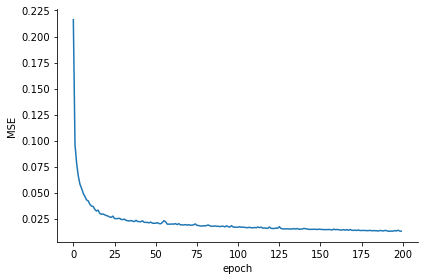

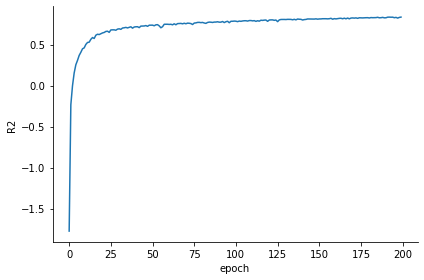

<AxesSubplot:xlabel='epoch', ylabel='R2'>

In [22]:
# Define parameters
epochs = 200 
lr = 0.1
batch_size = 10

# Instantiate optimizer and model
optimizer = SGD(lr=lr)
model = LinearRegression(dimension=x_train.shape[1], random_init=True, reduction='mean')

# Iterate over epochs
mse_losses = []
r2_scores = []
for _ in range(epochs):

    # Generate batches
    x_batches, y_batches = generate_batches(x_train, y_train, batch_size)

    # Iterate through batches
    for x, y in zip(x_batches, y_batches):
        
        # Determine the gradient for this batch
        gradient = model.gradient(x, y)
        
        # Update parameters using optimizer
        model.beta = optimizer.update(model.beta, gradient)

    # Get error
    y_hat = model.predict(x_test)
    mse = MSE(y_test, y_hat)
    r2 = R2(y_test, y_hat)
    
    # Append
    mse_losses.append(mse)
    r2_scores.append(r2)
    
plot_metric(y=mse_losses, show=True, save=True, x_label='epoch', y_label='MSE', name='f_mse_sgd_linear')
plot_metric(y=r2_scores, show=True, save=True, x_label='epoch', y_label='R2', name='f_r2_sgd_linear')

### Hyperparameter analysis

Now, we'll study the different hyperparameters in a structured way

ValueError: x and y must have same first dimension, but have shapes (6,) and (4, 6)

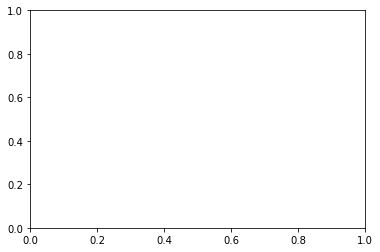

In [29]:
# Define parameters
degree = 5
epochs = [500, 1000, 1500, 2000]
lrs = [1e-3, 0.5e-3, 1e-2, 0.5e-2, 1e-1, 0.5e-1]
batch_sizes = [5, 20, 50, 100]

# Instantiate model
model = LinearRegression(dimension=x_train.shape[1], random_init=True, reduction='mean')

all_losses = []
all_scores = []
for batch_size in batch_sizes:
    mse_losses = []
    r2_scores = []
    for lr in lrs:
        optimizer = SGD(lr=lr)
        model.train(x_train, y_train, optimizer, 10, 200)

        y_hat = model.predict(x_test)
        mse = MSE(y_test, y_hat)
        r2 = R2(y_test, y_hat)

        # Append
        mse_losses.append(mse)
        r2_scores.append(r2)
        
    all_losses.append(mse_losses)
    all_scores.append(r2_scores)

plot_metric(y=all_losses, x=np.arange(len(lrs)), nx_ticks=lrs, show=True, save=False, x_label='lr', y_label='MSE', name='f_mse_sgd_linear')

plot_metric(y=all_scores, x=np.arange(len(lrs)), nx_ticks=lrs, show=True, save=False, x_label='lr', y_label='R2', name='f_r2_sgd_linear')